# 1º: Setting the work environment up

In [ ]:
!pip install fastf1

In [ ]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setup plotting
plotting.setup_mpl()

# Set the cache directory (need a 'cache' folder) avoid long waiting times
ff1.Cache.enable_cache('/content/drive/MyDrive/F1/cache')

# Ignore pandas warnings
pd.options.mode.chained_assignment = None

# 2º: Select the data

In [ ]:
# Session to be analyzed (Quali)
quali = ff1.get_session(2023, 'Monaco', 'Q')

In [ ]:
quali.load()

In [ ]:
# Get the quali laps
laps = quali.laps

In [ ]:
# Choose the drivers to be studied
driver1 = 'VER'
driver2 = 'ALO'

**Telemetry data**

In [ ]:
# Select the laps from both drivers
laps_driver1 = laps.pick_driver(driver1)
laps_driver2 = laps.pick_driver(driver2)

# Select the fastest lap
fastest_driver1 = laps_driver1.pick_fastest()
fastest_driver2 = laps_driver2.pick_fastest()

# Get fastest quali lap telemetry (.get_car_data doesn't work, we need the 'X' and 'Y' columns from .get_telemetry)
fastest_lap_driver1 = fastest_driver1.get_telemetry().add_distance()
fastest_lap_driver2 = fastest_driver2.get_telemetry().add_distance()

In [ ]:
# New column that indicates the driver
fastest_lap_driver1['Driver'] = driver1
fastest_lap_driver2['Driver'] = driver2

# Merge both lap telemetries
telemetry = fastest_lap_driver1.append(fastest_lap_driver2)

**Time delta**

Use with caution: this delta is an estimation, and not too accurate. So, it doesn't represent the real gap during the whole lap, but it shows us where a driver gained or lost time compared to another (plotted together with 'speed').

In [ ]:
delta_time, ref_tel, compare_tel = utils.delta_time(fastest_driver1, fastest_driver2)

**Defining minisectors**

In [ ]:
# Number of minisectors of equal size (you can change it)
num_minisectors = 25

# Track distance
total_distance = max(telemetry['Distance'])

# Generate =sized minisectors
minisector_length = total_distance / num_minisectors

In [ ]:
# Create a minisector column (assign every row a minisector depending on the current distance) - then we merge based on this column
telemetry['Minisector'] = (telemetry['Distance'] // minisector_length + 1)

In [ ]:
# New DF: we calculate avg. speed per driver per minisector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

In [ ]:
# Select the driver with the highest average speed (.loc extracts the rows)
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Delete speed column and rename the driver one
fastest_driver = fastest_driver[['Minisector', 'Driver']]
fastest_driver = fastest_driver.rename(columns={'Driver': 'Fastest_driver'})

In [ ]:
# Combine 2 DF: telemetry (main) with fastest_driver per minisector (based on minisector column, every minisector repeated, = driver)
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance
telemetry = telemetry.sort_values(by=['Distance'])

# New column: convert driver name to integer (if fastest = VER -> 1)
telemetry.loc[telemetry['Fastest_driver'] == driver1, 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == driver2, 'Fastest_driver_int'] = 2

# 3º: Plotting

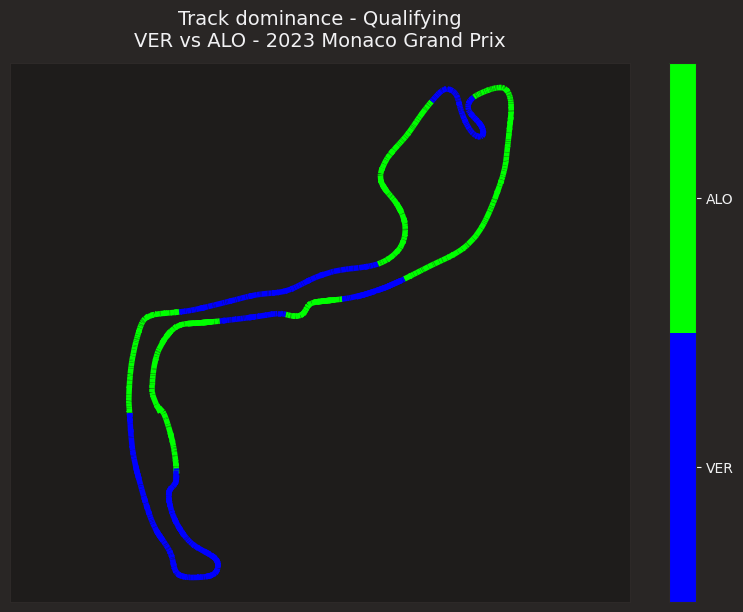

In [ ]:
# Where the car is at any moment in time ('x' n 'y' are columns in telemetry)
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

# Create points, and with them, segments (converting it to the appropriate numpy data types)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

# Coloring the plot (more colors: https://matplotlib.org/stable/tutorials/colors/colormaps.html)
colors = plt.get_cmap('brg', 2)
line_col = LineCollection(segments, norm=plt.Normalize(1, colors.N+1), cmap=colors, linewidth=6)   # line coordinates| map value-colors | colors
line_col.set_array(fastest_driver_array)                                                           # plot colors according to the fastest driver

# Create the plot (circuit shape)
plt.figure(figsize=(10, 7))
plt.title(f'Track dominance - {quali.name}\n'
          f'{driver1} vs {driver2} - {quali.event.year} {quali.event.EventName}', size=14)

plt.gca().add_collection(line_col)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

# Add a lateral colorbar to the plot (legend)
lateral_bar = plt.colorbar(mappable=line_col, boundaries=np.arange(1,4))          # data origin (fastest driver) | legend limits
lateral_bar.set_ticks(np.arange(1.5, 3.5))                                        # where the driver-marks are
lateral_bar.set_ticklabels([driver1, driver2])

#plt.savefig(f"/content/drive/MyDrive/F1/minisector_dominance.png", dpi=500)

plt.show()

# 4º: Discovering telemetry

In [ ]:
# Get fastest quali lap telemetry (.get_car_data because we just want to plot the telemetry, and it's recommended)
lap_telemetry_driver1 = laps_driver1.pick_fastest().get_car_data().add_distance()
lap_telemetry_driver2 = laps_driver2.pick_fastest().get_car_data().add_distance()

<Figure size 1500x1500 with 0 Axes>

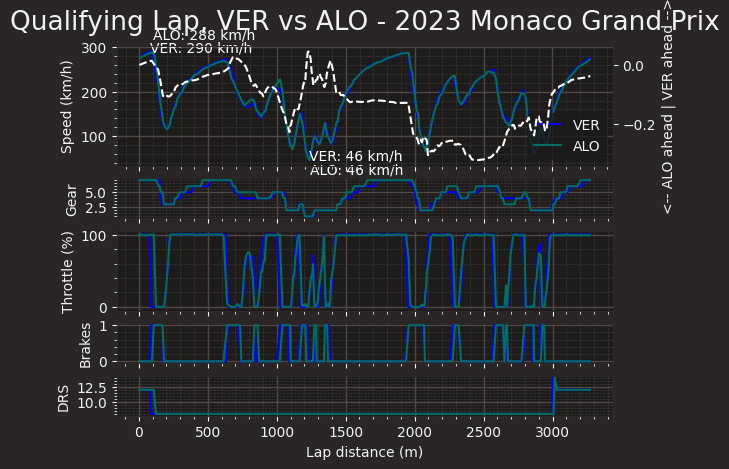

In [ ]:
plt.figure(figsize=(15, 15))

fig, ax = plt.subplots(5, gridspec_kw={'height_ratios': [3, 1, 2, 1, 1]})
ax[0].title.set_text(f"{quali.name} Lap, {driver1} vs {driver2} - {quali.event.year} {quali.event.EventName}")

driver1_color = ff1.plotting.driver_color(driver1)
driver2_color = ff1.plotting.driver_color(driver2)

# Speed
ax[0].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Speed'], label=driver1, color=driver1_color)
ax[0].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Speed'], label=driver2, color=driver2_color)
ax[0].set(ylabel='Speed (km/h)')
ax[0].legend(loc="lower right")

# Delta
twin = ax[0].twinx()   # right scale
twin.plot(ref_tel['Distance'], delta_time, '--', color='white')
twin.set_ylabel(f"<-- {driver2} ahead | {driver1} ahead -->")

# Maximum and Minimum speed of drivers
driver1_max_speed = lap_telemetry_driver1['Speed'].max()
driver1_min_speed = lap_telemetry_driver1['Speed'].min()
driver2_max_speed = lap_telemetry_driver2['Speed'].max()
driver2_min_speed = lap_telemetry_driver2['Speed'].min()
ax[0].annotate(f'{driver1}: {driver1_max_speed} km/h', (lap_telemetry_driver1['Distance'][lap_telemetry_driver1['Speed'].idxmax()], driver1_max_speed), textcoords="offset points", xytext=(0, 0), ha='left', color='white')   #valores x,y | posición texto
ax[0].annotate(f'{driver1}: {driver1_min_speed} km/h', (lap_telemetry_driver1['Distance'][lap_telemetry_driver1['Speed'].idxmin()], driver1_min_speed), textcoords="offset points", xytext=(0, 0), ha='left', color='white')
ax[0].annotate(f'{driver2}: {driver2_max_speed} km/h', (lap_telemetry_driver2['Distance'][lap_telemetry_driver2['Speed'].idxmax()], driver2_max_speed), textcoords="offset points", xytext=(0, 10), ha='left', color='white')
ax[0].annotate(f'{driver2}: {driver2_min_speed} km/h', (lap_telemetry_driver2['Distance'][lap_telemetry_driver2['Speed'].idxmin()], driver2_min_speed), textcoords="offset points", xytext=(0, -10), ha='left', color='white')

# Gear
ax[1].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['nGear'], label=driver1, color=driver1_color)
ax[1].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['nGear'], label=driver2, color=driver2_color)
ax[1].set(ylabel='Gear')

# Throttle
ax[2].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Throttle'], label=driver1, color=driver1_color)
ax[2].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Throttle'], label=driver2, color=driver2_color)
ax[2].set(ylabel='Throttle (%)')

# Brake
ax[3].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Brake'], label=driver1, color=driver1_color)
ax[3].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Brake'], label=driver2, color=driver2_color)
ax[3].set(ylabel='Brakes')

# DRS
ax[4].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['DRS'], label=driver1, color=driver1_color)
ax[4].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['DRS'], label=driver2, color=driver2_color)
ax[4].set(ylabel='DRS')
ax[4].set(xlabel='Lap distance (m)')

# Hide axis labels on subplots that are not on the outer edges
for a in ax.flat:
    a.label_outer()

plt.show()